In [22]:
import pandas as pd
import networkx as nx
import dowhy
from dowhy import CausalModel
from sklearn.linear_model import LinearRegression





In [3]:
train_path = 'Data/lucas0_text/lucas0_train.data'
test_path = 'Data/lucas0_text/lucas0_test.data'
targets_path = 'Data/lucas0_text/lucas0_train.targets'
param_path = 'Data/lucas0_text/lucas0.param'


column_names_targets = ['LC']  
column_names = [
    'SMOK',
    'YF',
    'ANX',
    'PP',
    'GEN',
    'ATDSD',
    'BED',
    'CAR',
    'FTG',
    'ALG',
    'COUGH'
]



train = pd.read_csv(train_path, names= column_names,delimiter='\\s+')
test = pd.read_csv(test_path)
targets = pd.read_csv(targets_path, names=column_names_targets)
param = pd.read_csv(param_path)

data = pd.concat([train, targets], axis=1)

num_samples = data.shape[0]

# change LC variable from (-1,1) t0 (0,1) for calculations
data['LC'] =data['LC'].replace(-1, 0)

In [4]:
data

,SMOK,YF,ANX,PP,GEN,ATDSD,BED,CAR,FTG,ALG,COUGH,LC
0,0,0,1,0,0,1,0,1,0,1,0,0
1,0,1,0,0,0,0,1,0,1,0,1,1
2,1,1,1,0,1,1,1,1,1,1,1,1
3,0,0,0,1,0,0,1,0,0,0,0,0
4,1,1,1,0,0,1,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,1,0,0,0,0,1,1,0,1,1
1996,1,1,1,0,0,0,0,0,1,0,1,1
1997,1,1,0,1,0,0,1,0,1,0,0,1
1998,1,1,1,0,1,1,0,1,1,0,1,1


## Draw Graph

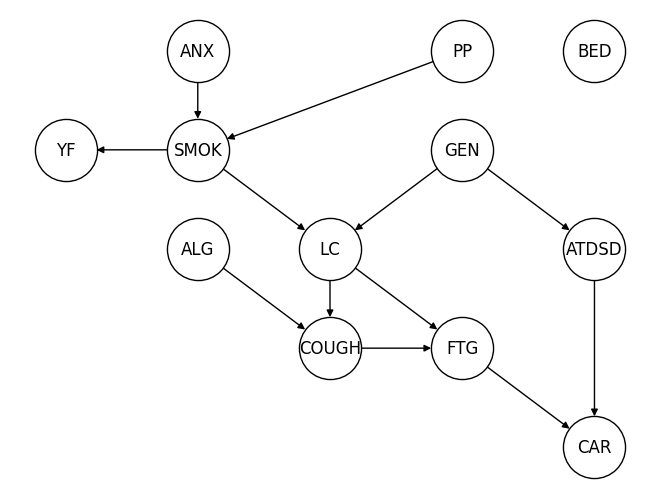

In [5]:
G = nx.DiGraph()

G.add_nodes_from(['ANX', 'PP', 'BED', 'YF', 'SMOK', 'GEN', 'ALG', 'LC', 'ATDSD', 'COUGH', 'FTG', 'CAR'])

G.add_edges_from([('ANX', 'SMOK'),
                   ('PP', 'SMOK'),
                   ('SMOK', 'YF'),
                   ('SMOK', 'LC'),
                   ('COUGH', 'FTG'),
                   ('GEN', 'LC'),
                   ('GEN', 'ATDSD'),
                   ('LC', 'FTG'),
                   ('LC', 'COUGH'),
                   ('FTG', 'CAR'),
                   ('ALG', 'COUGH'),
                   ('ATDSD', 'CAR')])

pos = {'ANX': (-1, 1), 'PP': (1, 1),
       'BED': (2, 1), 'YF': (-2, 0), 'GEN': (1, 0),
       'SMOK': (-1, 0), 'LC': (0, -1), 'COUGH': (0, -2),
       'FTG': (1, -2), 'CAR': (2, -3), 'ALG': (-1, -1), 'ATDSD': (2, -1)}

nx.draw(G, pos=pos, with_labels=True, node_size=2000, node_color='w', edgecolors='black')
nx.write_gml(G, "lung_cancer_graph.gml")

In [6]:
# a utility function to parse the .gml file to string
def gml_to_string(file):
    gml_str = ''
    with open(file, 'r') as file:
        for line in file:
            gml_str += line.rstrip()
    return gml_str

from IPython.display import Image, display


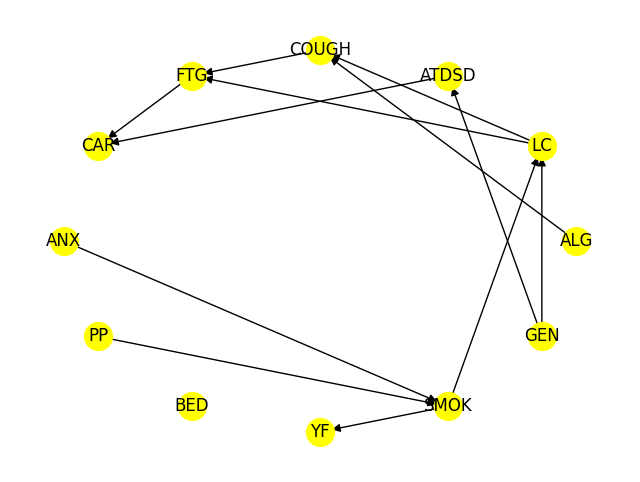

In [7]:
from IPython.display import Image, display

gml_graph = gml_to_string('lung_cancer_graph.gml')
# With GML string
model=CausalModel(
    data = data,
    treatment='COUGH',
    outcome='FTG',
    graph=gml_graph
)
model.view_model()

# ATE of Coughing on Fatigue

## 1. Find adj sets

In [61]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d               
────────(E[FTG|LC])
d[COUGH]           
Estimand assumption 1, Unconfoundedness: If U→{COUGH} and U→FTG then P(FTG|COUGH,LC,U) = P(FTG|COUGH,LC)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                             -1⎤
 ⎢  d         ⎛  d            ⎞  ⎥
E⎢──────(FTG)⋅⎜──────([COUGH])⎟  ⎥
 ⎣d[ALG]      ⎝d[ALG]         ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→FTG then ¬(U →→{ALG})
Estimand assumption 2, Exclusion: If we remove {ALG}→{COUGH}, then ¬({ALG}→FTG)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



#### Found Lung Cuncer as adj set with backdoor 

## 2. Make biased linear estimation

In [63]:

v0_vals = data['COUGH'].values.reshape(num_samples, 1)
y_vals = data['FTG'].values.reshape(num_samples, 1)

In [64]:
linear_regressor = LinearRegression() 
linear_regressor.fit(v0_vals, y_vals)
linear_regressor.coef_

array([[0.44200005]])

## Make unbiased linear estimation using backdoot adj set

In [65]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d               
────────(E[FTG|LC])
d[COUGH]           
Estimand assumption 1, Unconfoundedness: If U→{COUGH} and U→FTG then P(FTG|COUGH,LC,U) = P(FTG|COUGH,LC)

## Realized estimand
b: FTG~COUGH+LC
Target units: ate

## Estimate
Mean value: 0.3532092786978183

Causal Estimate is 0.3532092786978183


/Users/stathis/opt/anaconda3/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


## Make unbiased inverse propensity weighting using backdoot adj set

In [73]:
t_group = data[data["COUGH"]==1]
c_group = data[data["COUGH"]==0]

In [74]:
treatment_group_LC_0 = t_group[t_group["LC"]==0]
treatment_group_LC_1 = t_group[t_group["LC"]==1]

control_group_LC_0 = c_group[c_group["LC"]==0]
control_group_LC_1 = c_group[c_group["LC"]==1]

In [75]:
LC_0_group = pd.concat([treatment_group_LC_0,control_group_LC_0])
LC_1_group = pd.concat([treatment_group_LC_1,control_group_LC_1])


In [76]:
LC_1_group

,SMOK,YF,ANX,PP,GEN,ATDSD,BED,CAR,FTG,ALG,COUGH,LC
1,0,1,0,0,0,0,1,0,1,0,1,1
2,1,1,1,0,1,1,1,1,1,1,1,1
5,1,1,0,1,0,0,1,1,1,1,1,1
6,1,1,1,1,0,0,0,1,1,0,1,1
7,1,1,1,0,0,0,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1950,1,1,1,0,1,1,1,1,0,0,0,1
1953,1,1,1,0,0,0,1,1,1,0,0,1
1954,1,1,1,0,0,0,0,0,0,0,0,1
1963,1,1,1,1,0,1,1,1,0,0,0,1


In [77]:
propensity_score_LC_0 = len(treatment_group_LC_0)/len(LC_0_group)
propensity_score_LC_1 = len(treatment_group_LC_1)/len(LC_1_group)

In [78]:
number_of_all_samples = num_samples

weighted_sum_treatment_0 = sum(treatment_group_LC_0["FTG"])/ propensity_score_LC_0
weighted_sum_treatment_1 = sum(treatment_group_LC_1["FTG"])/ propensity_score_LC_1


mean_treatment2 = weighted_sum_treatment_0 + weighted_sum_treatment_1 
mean_treatment2 = mean_treatment2/number_of_all_samples

weighted_sum_control_0 = sum(control_group_LC_0["FTG"])/(1 - propensity_score_LC_0)
weighted_sum_control_1 = sum(control_group_LC_1["FTG"])/ (1 - propensity_score_LC_1)

mean_control2 = weighted_sum_control_0 + weighted_sum_control_1 
mean_control2 = mean_control2/number_of_all_samples

ATE_IPW2 = mean_treatment2-mean_control2
print("ATE after IPW:", ATE_IPW2)

ATE after IPW: 0.3507998093204841


In [79]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_weighting")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d               
────────(E[FTG|LC])
d[COUGH]           
Estimand assumption 1, Unconfoundedness: If U→{COUGH} and U→FTG then P(FTG|COUGH,LC,U) = P(FTG|COUGH,LC)

## Realized estimand
b: FTG~COUGH+LC
Target units: ate

## Estimate
Mean value: 0.35197519148673784

Causal Estimate is 0.35197519148673784


# 5. Causal Discovery

In [23]:
from itertools import combinations

import cdt
# cdt.SETTINGS.rpath = '/usr/local/bin/Rscript' # for macOS
cdt.SETTINGS.rpath = 'C:/Program Files/R/R-4.3.3/bin/Rscript' # for Windows, here you may need to adjust the path based on your R Version

from dowhy import CausalModel
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from numpy.random import normal
import pandas as pd
import pingouin as pg
import dowhy.graph_learners.ges as dowhy_ges
import ges

alpha = 0.05 # significance level

## 5.1 Constraint-based Causal Discovery

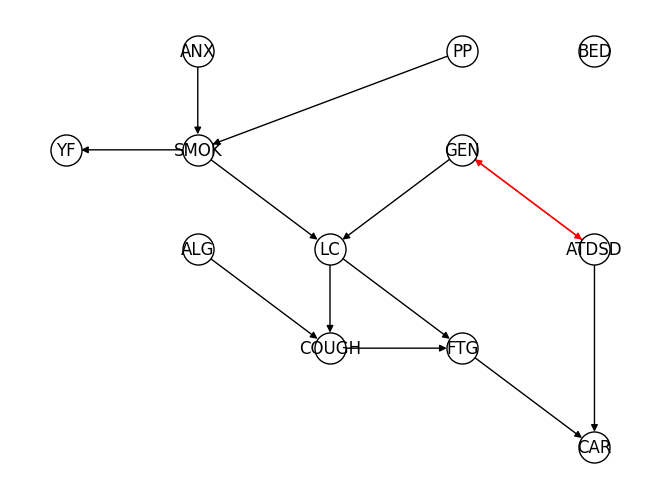

In [20]:
pc = cdt.causality.graph.PC(CItest="gaussian", alpha=alpha)
pc_graph = pc.create_graph_from_data(data)
colors = ['red'  if (y,x) in pc_graph.edges() else 'black' for (x,y) in pc_graph.edges()]
nx.draw(pc_graph, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)

## 5.2 Score-based Causal Discovery

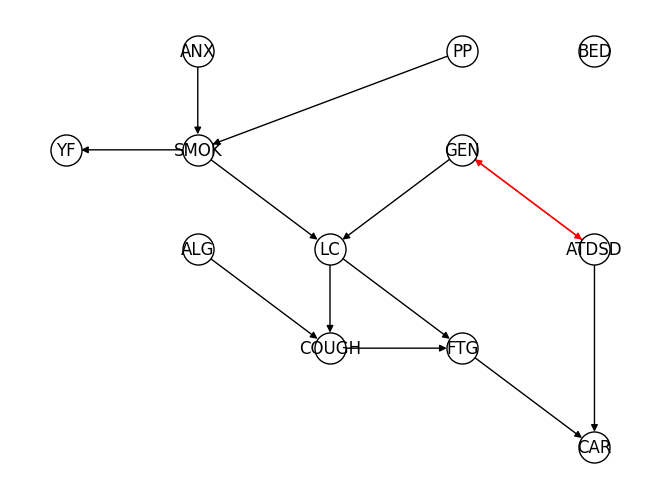

In [21]:
result, score = ges.fit_bic(data.to_numpy()) # The result is a CPDAG represented by an adjacency matrix
ges_graph = nx.relabel_nodes(nx.DiGraph(result), {idx: i for idx, i in enumerate(data.columns)})
colors = ['red'  if (y,x) in ges_graph.edges() else 'black' for (x,y) in ges_graph.edges()]
nx.draw(ges_graph, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)

### Remarks

- Both methods (PC and GES) arrive at the same causal graph
- Almost all of the causal relations agree with the graph provided in the dataset description, apart from the causal relation between Genetics and Attention Disorder, as the orientation of the edge could not be determined.
- It could be argued that, since Genetics are defined before birth and cannot be changed thereafter, the attention disorder of a human cannot possibly affect Genetics. Thus, the direction of the edge between Genetics and Attention Disorder could be provided as Background Knowledge (even backed by literature, for example: https://www.nature.com/articles/s41380%E2%80%90018%E2%80%900070%E2%80%900)